### A Start at some correspondence analysis like I did for Corpus Linguistics

In [24]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # for fancy interactive plot
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import os # to check if directory exists and create it if it doesn't
from datetime import datetime # to parse speech date
from nrclex import NRCLex
import spacy
import en_core_web_md
import csv
import prince # for correspondence analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text
stopwords = pd.read_table('./word_lists/kaggle_stopwords.txt')
import unicodedata

[Skip to load previously saved contingency table](#loadctab)

In [112]:
# Load up the files
paths = ['./GWB/'] 
list_of_files = []

for path in paths:
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.txt'):
                list_of_files.append(os.path.join(root,file))

speeches = []
for file in list_of_files:
    with open(file, encoding='utf-8') as f:
        #print(file)
        text = f.read()
    f.close()
    speeches.append(text)

#clean out goofy unicode  space characters 
speeches = [unicodedata.normalize("NFKD", speech) for speech in speeches if len(speech)>0 ]

# remove [stuff] in between square brackets
def remove_bracket(text):
    return re.sub('(\[[^w]*\]\s)', '',text)
speeches = [remove_bracket(speech) for speech in speeches]

# lemmatize text with spacy
nlp = spacy.load("en_core_web_md", exclude=["parser", "ner"])
for i, doc in enumerate(nlp.pipe(speeches)):
    words_lemmas_list = [token.lemma_ for token in doc]
    speeches[i]= ' '.join(words_lemmas_list)
    
# Remove punctuation - only care about words here
speeches = [re.sub(r'[^\w\s]', '', speech) for speech in speeches]

# remove numbers
speeches = [re.sub(r'\d', '', speech) for speech in speeches]

# Clean up whitespace
speeches = [re.sub('[\s+]', ' ', speech) for speech in speeches]
    
# Combine speeches and filenames
speeches = list(zip(speeches, list_of_files))
    
def get_source(text):
    regex = "[^./][a-zA-Z]+[^/]"
    string = re.findall(regex, str(text))[0]
    if string == 'speeches': string = 'oba'
    if string == 'NYTimes': string = 'nyt'
    return string.lower()

def get_date(text):
    regex = "([0-9]+[\-][0-9]+[\-][0-9]+)"
    return re.findall(regex, str(text))[0]

def get_filename(text):
    regex = "[-]([a-zA-Z]+)"
    return re.findall(regex, str(text))[0]

dates = pd.read_csv('speech_and_date_gwb.csv') # day-month-year
dates['date'] = pd.to_datetime(dates['date'], format='%d/%m/%Y')
cols_speeches = ['text', 'filepath']

text_df = pd.DataFrame(speeches, columns=cols)

text_df = pd.merge(text_df, dates, how='left', on='filepath')
text_df.sort_values(by='date')
text_df['source'] = text_df['filepath'].apply(get_source)
text_df.set_index('date', inplace=True)
text_df.head(3)

,text,filepath,source
date,,,
2007-11-27,thank you for come Prime Minister Olmert Pre...,./GWB/remarks-the-annapolis-conference-annapol...,gwb
2002-06-06,good evening during the next few minute I wa...,./GWB/address-the-nation-the-proposed-departme...,gwb
2007-04-16,our Nation be shock and sadden by the news of ...,./GWB/remarks-the-shootings-virginia-tech-blac...,gwb


<A HREF="https://regexr.com/">RegExr</A>

In [115]:
#Load SpaCy English Model
nlp = en_core_web_md.load()

In [118]:
punc = '''!()-[]{};:"\,<>./?—â@#$%^&*_~â'''
sources = ['text_oba', 'text_nyt', 'text_wsj']
sources = ['text']
for source in sources:
    for i in range(len(df[source])):
        nopunc = ''.join([letter if letter not in punc else " " for letter in df[source].iloc[i] ])
        df.loc[i, source] =re.sub(' +', ' ', nopunc).replace('\n','').replace("' ", " ").strip()

### <A HREF="https://www.nltk.org/index.html">NLTK Documentation</A> <A HREF="https://www.tomaarsen.com/nltk/api/nltk.html">API reference</A>

In [231]:
# switch for gwb speeches
df = text_df.copy()

# And shorten GWB speech names
remove_text = ['remarks-', 'address-', 'videotaped-', 'press-', 
              'message-', 'address-', 'statement-', 'proclamation-',
              'signing-', 'accepting-', 'fact-sheet-', 'following-',
              'announcing-the-', 'setting-the-record-straight-', 'accepting-the-',
              'briefing-', 'joint-statement-', 'signing-the-', 
               'the-', 'statement-', 'press-briefing-', 'before-']

for i in range(len(df['filepath'])):
    for this in remove_text:
        df['filepath'].iloc[i] = df['filepath'].iloc[i].replace(this, '')
df['filepath'] = [file[6:-4] for file in df['filepath']]
df['filepath'] = [file[0:20] for file in df['filepath']]
df['date'] = [str(date)[0:10] for date in df.index]
df['filename'] = [str(x) + '-' + str(y) for x, y in zip(df['date'], df['filepath'])]
df.drop(['date', 'filepath'], axis=1, inplace=True)

In [232]:
# Run this if you want to remove stop words before creating contingency table
kaggle_file = open("./word_lists/kaggle_stopwords.txt", "r")
kaggle_data = kaggle_file.read()
kaggle_list = [word for word in kaggle_data.split('\n')]
kaggle_file.close()
my_list = ['thats', 'just', 'im', 'did', 'thing', 'mr', 'al', 'thank', 'okay', 'thank','thanks', 
           'question', 'joshua', 'president', 'obama', 'â', u'\x99s', u'\x99t', u'\x99ve', u'\x99m',u'\x99re', '\x99']
stop_list = list(set(kaggle_list) | set(my_list))
stop_words = ENGLISH_STOP_WORDS.union(stop_list)

#for source in sources:
#    for i in range(len(df[source])):
#        df.loc[i, source] = ' '.join([word for word in df[source][i].split() if word.lower() not in stop_words])

# for gwb speeches
for i in range(len(df)):
        df['text'].iloc[i] = ' '.join([word for word in df['text'].iloc[i].split() if word.lower() not in stop_words])

In [233]:
# A little more clean up
nlp = spacy.load("en_core_web_md", exclude=["parser", "ner"])
for source in sources:
    # lemmatize text with spacy
    #clean out goofy unicode  space characters 
    #df[source] = [unicodedata.normalize("NFKD", speech) for speech in df[source] if len(speech)>0 ]
    df['text'] = [unicodedata.normalize("NFKD", speech) for speech in df['text'] if len(speech)>0 ]
    nlp = spacy.load("en_core_web_md", exclude=["parser", "ner"])
    for i, doc in enumerate(nlp.pipe(df[source])):
        words_lemmas_list = [token.lemma_ for token in doc]
        df[source][i]= ' '.join(words_lemmas_list)
#df.dropna(axis=0, inplace=True)

In [234]:
# Go through word by word and remove this: â
# switch for GWB speeches - line 5 & 6
for source in sources:
    for i in range(len(df[source])):
        #df.loc[i, source] = ' '.join([word.replace("â", "") for word in df[source][i].split()])
        df['text'].iloc[i] = ' '.join([word.replace("â", "") for word in df['text'].iloc[i].split()])
# Finally, got rid of that stupid thing!

In [235]:
# Create a frequency list of all words in all Obama speeches

# How to flatten a list
#[item for sublist in list_of_lists for item in sublist]

#freqlist = nltk.FreqDist([word.lower() for text in df['text_oba'] for word in text.split()])
# Switch for GWB speeches
freqlist = nltk.FreqDist([word.lower() for text in df['text'] for word in text.split()])
freqlist

FreqDist({'people': 579, 'america': 504, 'work': 390, 'country': 364, 'new': 361, 'world': 337, 'help': 329, 'american': 329, 'nation': 317, 'iraq': 311, ...})

In [236]:
sorted(dict(freqlist).items(),key=lambda x:x[1], reverse=True)[:20]

[('people', 579),
 ('america', 504),
 ('work', 390),
 ('country', 364),
 ('new', 361),
 ('world', 337),
 ('help', 329),
 ('american', 329),
 ('nation', 317),
 ('iraq', 311),
 ('time', 297),
 ('government', 290),
 ('year', 287),
 ('security', 273),
 ('united', 266),
 ('come', 254),
 ('great', 252),
 ('terrorist', 249),
 ('know', 248),
 ('congress', 246)]

In [237]:
# list of all the words in the freqlist which is from all 100 documents
words = list(set(dict(freqlist).keys()))
# was getting a weird error below, just making sure all are strings, no numbers
words = [str(word) for word in words] 

### Create Contingency Table - counts of all words in all the documents

In [238]:
# Get counts of all words in 'words' for each speech/article
# I'm doing this the slow way so I can be sure the results are correct.
# I was getting weird numbers using other methods, 
#    like using sklearn countvectorizer I was getting 2900 for 'deepwater' when it should be 4
# I realize this is ugly and slow
counts = []
# Switched 'text_oba' to 'text' for GWB speeches
for i in range(len(df['text'])):
    sums = []
    for word in words:
        summ = 0
        for docword in df['text'].iloc[i].split():
            if docword == word:
                summ+=1
        sums.append(summ)
    counts.append(sums)

In [239]:
# Oh man, this is so ugly, just brute force, no style or class. Oh well, it works!
totalcounts = []
for i in range(len(words)):
    summ = 0
    for j in range(len(counts)):
        summ += counts[j][i]
    totalcounts.append(summ)      

In [ ]:
# total count of 'deepwater' should be 4 from one speech for Obama
word = 'deepwater'
[vectr[words.index(word)] for vectr in counts if vectr[words.index(word)]>0]
# Now with stopwords removed its only 2, wtf????

In [254]:
# Contingency table
df.dropna(axis=0, inplace=True)
filenames = df['filename']
conttab = pd.DataFrame(counts, columns = words, index = filenames, dtype='int')

In [255]:
conttab.loc['sum',:] = conttab.sum(axis=0)

In [256]:
conttab

,massive,requirement,inflation,belarus,waitress,cockpit,summarize,memorandum,temporarily,bed,...,inevitability,acquire,wrong,clyburn,significant,plo,sts,robb,type,regard
filename,,,,,,,,,,,,,,,,,,,,,
2007-11-27-annapolis-conference,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-06-06-nation-proposed-depa,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2007-04-16-shootings-virginia-t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-04-10-iraqi-people,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-20-joint-session-congre,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-07-fannie-mae-and-fredd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-05-16-national-security-ad,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-12-20-ari-fleischer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [257]:
# And here is the full Contingency Table, sorted with most frequent words first
conttab.sort_values(by='sum', axis=1, ascending=False, inplace=True)
conttab.drop('sum', inplace=True)
conttab.sort_index(inplace=True)
conttab

,people,work,country,help,new,world,american,nation,time,year,...,potter,oconnor,rick,jackson,toni,baucus,alma,ohio,germany,nasdaq
filename,,,,,,,,,,,,,,,,,,,,,
2001-01-20-inaugural-52,1.0,5.0,9.0,0.0,5.0,3.0,5.0,11.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-22-participants-march-f,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-29-executive-orders-wit,5.0,9.0,2.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-16-joint-president-geor,5.0,2.0,5.0,2.0,2.0,0.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-29-presidents-news-conf,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-04-presidential-nominat,12.0,26.0,31.0,13.0,10.0,12.0,10.0,1.0,6.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-09-07-fannie-mae-and-fredd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01-senate-passage-india,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save contingency table, change destination file name

In [258]:
# Save table so we don't have to do this again
#conttab.to_csv('obamaContingencyTable_noSW.csv')
conttab.to_csv('GWB_ContingencyTable_noSW.csv')

<a id='loadctab'>Load Contingency Table</a>

In [14]:
################################ LOAD CONTINGENCY TABLE ###############################
# Read in saved contingency table
ctab = pd.read_csv('obamaContingencyTable_noSW.csv',index_col=0)
# Shorten row index names to date only
ctab = ctab.rename(index = lambda x: x[0:10])

In [15]:
# Let's look at the 150 most common words
ctabshort=ctab.iloc[:, : 150]

<A HREF="https://github.com/MaxHalford/prince#correspondence-analysis-ca">Prince Correspondence Analysis</A>

<A HREF="https://pypi.org/project/prince/#history">Prince version history</A>

In [16]:
# Check prince version
!pip show prince
# ok 0.8.2 

Name: prince
Version: 0.8.2
Summary: Factor analysis in Python: PCA, CA, MCA, MFA, FAMD, GPA
Home-page: 
Author: Max Halford
Author-email: maxhalford25@gmail.com
License: MIT
Location: /home/muddy/.local/lib/python3.10/site-packages
Requires: altair, pandas, scikit-learn
Required-by: 


In [19]:
ca = prince.CA(n_components=2,
               n_iter=3,copy=True,
               check_input=True,
               engine='sklearn',
               random_state=33)

In [20]:
ctabshort.columns.rename('words', inplace=True)
ctabshort.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort)

# Something's gone wrong with the Prince correspondency analysis!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Just stopped working
# The prince github repository says he fixed famd transform 4 days ago... perhaps not
# https://github.com/MaxHalford/prince
# Can try
# pip install prince==0.8.1

In [21]:
ca.row_coordinates(ctabshort).head()

,0,1
speeches,,
2008-06-04,0.031787,0.115691
2008-11-05,-0.148304,-0.108055
2009-01-05,0.207110,-0.251151
2009-01-20,-0.241639,0.064270
2009-04-02,-0.244059,-0.121137


In [22]:
ca.column_coordinates(ctabshort).head()

,0,1
words,,
people,-0.238747,0.135556
work,0.100527,-0.082197
year,0.256594,0.011465
know,0.022138,-0.055964
new,0.117196,-0.145937


In [23]:
ax = ca.plot_coordinates(X=ctabshort,
                         ax=None,
                         figsize=(10, 10),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True
                        )
plt.xlim([-1.7, 1.2])
plt.ylim([-1.0, 2.0])
plt.show()

AttributeError: 'CA' object has no attribute 'plot_coordinates'

<A HREF="https://matplotlib.org/cheatsheets/cheatsheets.pdf">Matplotlib basic cheat sheet</A><BR>
    <A HREF="https://matplotlib.org/cheatsheets/">other matplotlib cheat sheets</A>

From NRC analysis the speech with particularly high anger value was 2015-01-08
and particularly high positive value on 2014-03-07

/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


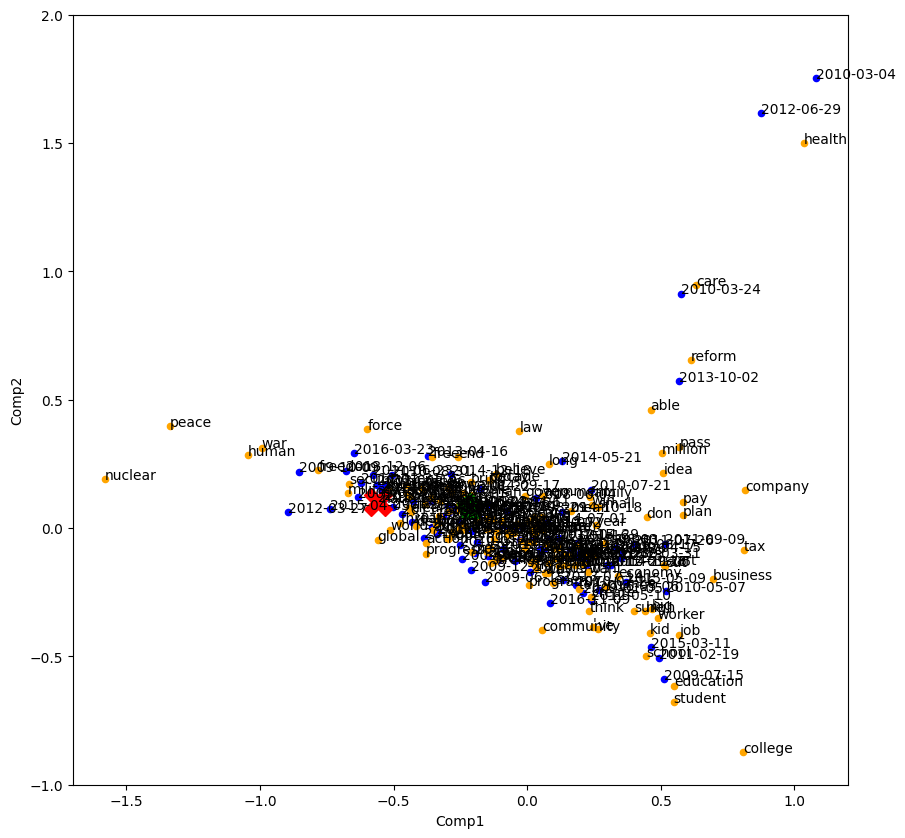

In [24]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=ca.row_coordinates(ctabshort)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-1.7, 1.2])
plt.ylim([-1.0, 2.0])
plt.show()

### Try correspondence analysis on a pre-selected list of words

In [35]:
# Load words from file
# topic words from topic modeling: "./word_lists/topic-words.txt"
# a custom list: "./word_lists/customlist.txt"
# common adjective: "./word_lists/adjectives.txt"
# common adverbs: "./word_lists/adverbs.txt"
# function words: "./word_lists/function-words.txt"
wordList = pd.read_csv("./word_lists/hope_words.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])

In [36]:
# Make a short contingency list using topic words
ctabshort2 = ctab.loc[ : , [col for col in ctab.columns if col in list(wordList['word'])]]

# Keep it to the most common 150 words
if np.shape(ctabshort2)[1] > 150:
    ctabshort2=ctabshort2.iloc[:, : 150]
    
ctabshort2.columns.rename('words', inplace=True)
ctabshort2.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort2)

AttributeError: 'CA' object has no attribute 'fit'

In [ ]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=ca.row_coordinates(ctabshort2)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort2)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

#plt.xlim([-0.5, 1.5])
#plt.ylim([-0.6, 0.4])
plt.show()

### Now try using the most frequent 150 words after removing the Kaggle 700 stop words

In [ ]:
# Load words from file
# Kaggle stop words: "./word_lists/kaggle_stopwords.txt"
wordList = pd.read_csv("./word_lists/kaggle_stopwords.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])

In [ ]:
number_of_words = 400
# Make a short contingency list removing the Kaggle stop words
ctabshort3 = ctab.loc[ : , [col for col in ctab.columns if col not in list(wordList['word'])]]

# Keep it to the most common 150 words
if np.shape(ctabshort3)[1] > number_of_words:
    ctabshort3=ctabshort3.iloc[:, : number_of_words]
    
ctabshort3.columns.rename('words', inplace=True)
ctabshort3.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort3)

In [ ]:
date1 = '2015-01-08' # date 1 is red X
date2 = '2011-05-02' # date 2 is green pentagon
df1=ca.row_coordinates(ctabshort3)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort3)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches - blue
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words - orange
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

#plt.xlim([0.4, 1.0])
#plt.ylim([-0.25, 0.25])
plt.show()

In [27]:
# LETS TRY THIS CODE
# https://okomestudio.net/biboroku/2014/05/brand-positioning-by-correspondence-analysis/

In [28]:
#!/usr/bin/env python2.7
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd


class CA(object):
    """Simple corresondence analysis.
    
    Inputs
    ------
    ct : array_like
      Two-way contingency table. If `ct` is a pandas DataFrame object,
      the index and column values are used for plotting.
    Notes
    -----
    The implementation follows that presented in 'Correspondence
    Analysis in R, with Two- and Three-dimensional Graphics: The ca
    Package,' Journal of Statistical Software, May 2007, Volume 20,
    Issue 3.
    """

    def __init__(self, ct):
        self.rows = ct.index.values if hasattr(ct, 'index') else None
        self.cols = ct.columns.values if hasattr(ct, 'columns') else None
        
        # contingency table
        N = np.matrix(ct, dtype=float)

        # correspondence matrix from contingency table
        P = N / N.sum()

        # row and column marginal totals of P as vectors
        r = P.sum(axis=1)
        c = P.sum(axis=0).T

        # diagonal matrices of row/column sums
        D_r_rsq = np.diag(1. / np.sqrt(r.A1))
        D_c_rsq = np.diag(1. / np.sqrt(c.A1))

        # the matrix of standarized residuals
        S = D_r_rsq * (P - r * c.T) * D_c_rsq

        # compute the SVD
        U, D_a, V = svd(S, full_matrices=False)
        D_a = np.asmatrix(np.diag(D_a))
        V = V.T

        # principal coordinates of rows
        F = D_r_rsq * U * D_a

        # principal coordinates of columns
        G = D_c_rsq * V * D_a

        # standard coordinates of rows
        X = D_r_rsq * U

        # standard coordinates of columns
        Y = D_c_rsq * V

        # the total variance of the data matrix
        inertia = sum([(P[i,j] - r[i,0] * c[j,0])**2 / (r[i,0] * c[j,0])
                       for i in range(N.shape[0])
                       for j in range(N.shape[1])])

        self.F = F.A
        self.G = G.A
        self.X = X.A
        self.Y = Y.A
        self.inertia = inertia
        self.eigenvals = np.diag(D_a)**2

    def plot(self):
        """Plot the first and second dimensions."""
        xmin, xmax = None, None
        ymin, ymax = None, None
        if self.rows is not None:
            for i, t in enumerate(self.rows):
                x, y = self.F[i,0], self.F[i,1]
                plt.text(x, y, t, va='center', ha='center', color='r')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.F[:, 0], self.F[:, 1], 'ro')

        if self.cols is not None:
            for i, t in enumerate(self.cols):
                x, y = self.G[i,0], self.G[i,1]
                plt.text(x, y, t, va='center', ha='center', color='b')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.G[:, 0], self.G[:, 1], 'bs')

        if xmin and xmax:
            pad = (xmax - xmin) * 0.1
            plt.xlim(xmin - pad, xmax + pad)
        if ymin and ymax:
            pad = (ymax - ymin) * 0.1
            plt.ylim(ymin - pad, ymax + pad)

        plt.grid()
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')

    def scree_diagram(self, perc=True, *args, **kwargs):
        """Plot the scree diagram."""
        eigenvals = self.eigenvals
        xs = np.arange(1, eigenvals.size + 1, 1)
        ys = 100. * eigenvals / eigenvals.sum() if perc else eigenvals
        plt.plot(xs, ys, *args, **kwargs)
        plt.xlabel('Dimension')
        plt.ylabel('Eigenvalue' + (' [%]' if perc else ''))


/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


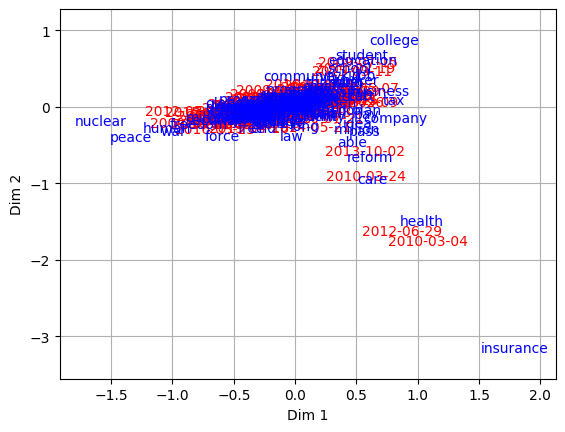

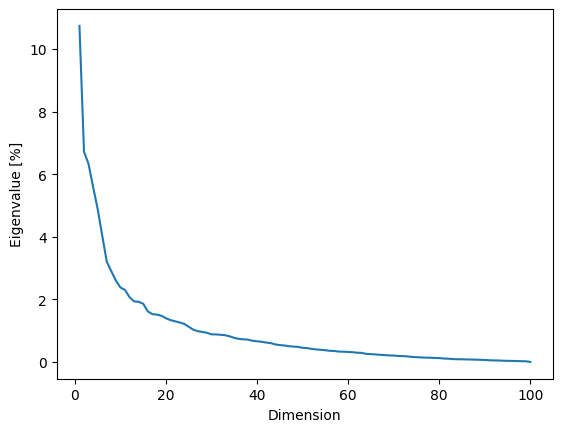

In [38]:
################################ LOAD CONTINGENCY TABLE ###############################
# Read in saved contingency table
ctab = pd.read_csv('obamaContingencyTable_noSW.csv',index_col=0)
# Shorten row index names to date only
ctab = ctab.rename(index = lambda x: x[0:10])
# Let's look at the 150 most common words
ctabshort=ctab.iloc[:, : 150]


df = pd.io.parsers.read_csv('obamaContingencyTable_noSW.csv')
df = df.set_index('speech')

#print(df.describe())
#print( df.head())

ca = CA(ctabshort)

plt.figure(100)
ca.plot()

plt.figure(101)
ca.scree_diagram()

plt.show()